 # FashionMNIST

 ## Задание 7.2

<img src="https://emiliendupont.github.io/imgs/mnist-chicken/mnist-and-fashion-examples.png">

На практике построим нейронную сеть для классификации картиной. В качестве входных данных используются картинки одежды (в градациях серого, то есть цветовых каналов не 3, а 1). По входной картинке нужно предсказать тип одежды.

In [1]:
# !pip install torchvision

import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision

Скачаем обучающую и контрольную выборки.

In [2]:
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=None)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=None)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes  = {0: "T-shirt/top", 1: "Trouser", 2: "Pullover",
            3: "Dress", 4: "Coat", 5: "Sandal", 
            6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle boot"}

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



Каждая картинка имеет класс от 0 до 9, расшифровка меток класса:  

|class_id|class_name|
|----|----|
|0| T-shirt/top|
|1| Trouser|
|2| Pullover|
|3| Dress|
|4| Coat|
|5| Sandal|
|6| Shirt|
|7| Sneaker|
|8| Bag|
|9| Ankle boot| 

<h2 style="text-align: center;"><b>Задание</b></h2>

Посмотрите на датасет.
* Сколько картинок в train? В test?
* Равномерно ли распределено количество объектов разных классов в train датасете (это можно понять, поработав с полем `train_data` у переменной `trainset`)? в test?
* Выведите несколько картинок с помощью `pyplot`

Используя материалы семинаров по многослойным  и свёрточным сетям, напишите:
1.  Многослойную нейронную сеть MLP (Multi-Layer Perceptron) классифицирующую этот датасет
2. Свёрточную сеть, классифицирующую этот датасет
3. Сравните их качество (по графикам лосса и по Accuracy Score)

Если качество, которое получается у  нейросети, выше 95%, то Вы решили задачу с точностью, которую можно использовать в жизни.

60000 10000
train: tensor([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000])
test: tensor([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000])
Ankle boot


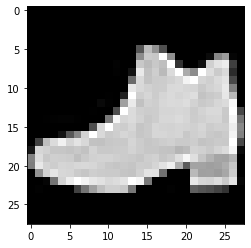

Sandal


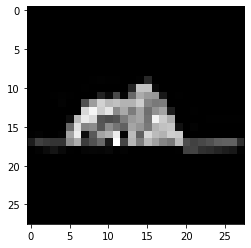

T-shirt/top


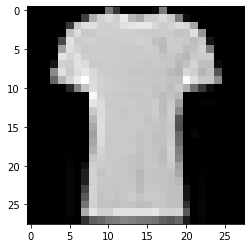

In [3]:
print(len(trainset), len(testset))
traindist = trainset.targets.unique(return_counts=True)[1]
print('train:', traindist)
testdist = testset.targets.unique(return_counts=True)[1]
print('test:', testdist)
for i in [15, 734, 5999]:
  print(classes[trainset.targets[i].item()])
  plt.imshow(trainset.data[i], cmap='gray')
  plt.show()

In [4]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Conv2D
from tensorflow.keras.utils import to_categorical
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

# Эти библиотеки отключают лишние предупреждения от библиотек, в частности,
# tensorflow, чтобы не засорять вывод наших результатов
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False
import warnings
warnings.filterwarnings("ignore")

# keras является оболочкой для более низкоуровневых библиотек, 
# в нашем случае мы используем tensorflow, у которого на данный момент 
# поддерживаются две версии, установим первую
import tensorflow as tf

In [5]:
'''class PlotLearning(keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if 'val' not in x]
        
        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric)
                
            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()'''

'class PlotLearning(keras.callbacks.Callback):\n    """\n    Callback to plot the learning curves of the model during training.\n    """\n    def on_train_begin(self, logs={}):\n        self.metrics = {}\n        for metric in logs:\n            self.metrics[metric] = []\n            \n\n    def on_epoch_end(self, epoch, logs={}):\n        # Storing metrics\n        for metric in logs:\n            if metric in self.metrics:\n                self.metrics[metric].append(logs.get(metric))\n            else:\n                self.metrics[metric] = [logs.get(metric)]\n        \n        # Plotting\n        metrics = [x for x in logs if \'val\' not in x]\n        \n        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))\n        clear_output(wait=True)\n\n        for i, metric in enumerate(metrics):\n            axs[i].plot(range(1, epoch + 2), \n                        self.metrics[metric], \n                        label=metric)\n            if logs[\'val_\' + metric]:\n            

In [6]:
#callbacks_list = [PlotLearning()]
X_train = tf.cast(trainset.train_data, tf.float32)
y_train = trainset.targets
X_test = tf.cast(testset.train_data, tf.float32)
y_test = testset.targets
X_train = X_train/255
X_test = X_test/255
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)
model = Sequential()
model.add(Flatten(input_shape=X_train[0].shape))
model.add(Dense(units=128, input_shape=X_train[0].shape))
model.add(Activation('relu'))
model.add(Dense(units=10))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs = 50, steps_per_epoch=None)

Epoch 1/50
1223/1875 [==================>...........] - ETA: 2s - loss: 0.5403 - accuracy: 0.8113

KeyboardInterrupt: ignored

In [ ]:
model.summary()

In [ ]:
model.evaluate(X_test, y_test, steps=None)

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.xlabel('epoch')
plt.legend(['loss', 'acc'], loc='upper left')
plt.xticks(np.arange(1, len(history.history['loss']) + 1, 1))
plt.show()

In [7]:
X_train, X_test = X_train.reshape((60000, 28, 28, 1)), X_test.reshape((10000, 28, 28, 1))

In [8]:
#callbacks_list = [PlotLearning()]
model = Sequential()
model.add(Conv2D(24, (3, 3), padding='same', input_shape=X_train[0].shape))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy',
                   optimizer='adam',
                   metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs = 10, steps_per_epoch=None)

Epoch 1/10
1875/1875 [==============================] - 21s 5ms/step - loss: 0.3970 - accuracy: 0.8594
Epoch 2/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2632 - accuracy: 0.9034
Epoch 3/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2162 - accuracy: 0.9205
Epoch 4/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1789 - accuracy: 0.9344
Epoch 5/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.1477 - accuracy: 0.9452
Epoch 6/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.1181 - accuracy: 0.9567
Epoch 7/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0970 - accuracy: 0.9647
Epoch 8/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0791 - accuracy: 0.9709
Epoch 9/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0624 - accuracy: 0.9778
Epoch 10/10
1875/1875 [==============================] - 9s 5ms/step - loss:

In [9]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 24)        240       
                                                                 
 activation_2 (Activation)   (None, 28, 28, 24)        0         
                                                                 
 flatten_1 (Flatten)         (None, 18816)             0         
                                                                 
 dense_2 (Dense)             (None, 64)                1204288   
                                                                 
 dense_3 (Dense)             (None, 10)                650       
                                                                 
Total params: 1,205,178
Trainable params: 1,205,178
Non-trainable params: 0
_________________________________________________________________


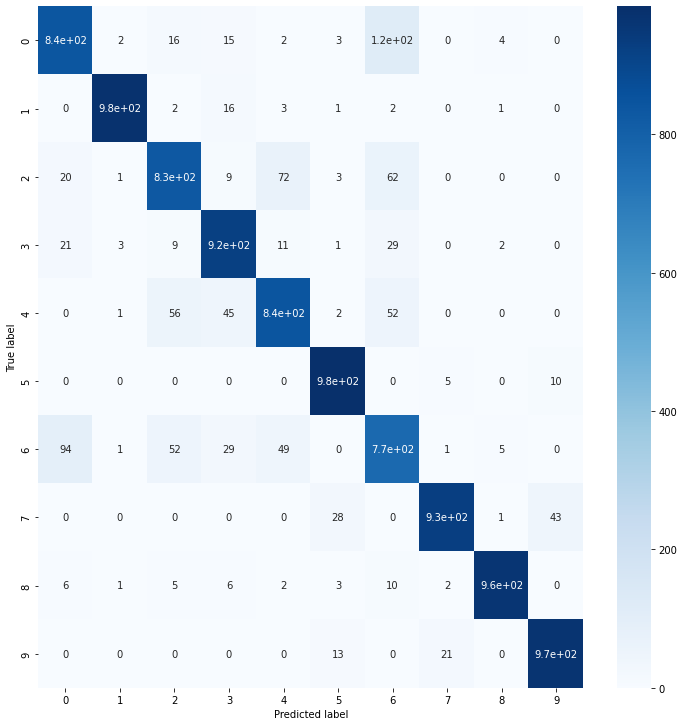

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(1)
y_true = y_test.argmax(1)
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
figure = plt.figure(figsize=(10, 10))
sns.heatmap(confusion_mtx, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
model.evaluate(X_test, y_test, steps=None)

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.xlabel('epoch')
plt.legend(['loss', 'acc'], loc='upper left')
plt.xticks(np.arange(0, len(history.history['loss']), 1))
plt.show()